In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import copy
import sys
import datetime
import iris
from pyhdf.SD import SD, SDC
import time
from cis.data_io.gridded_data import GriddedDataList

os.environ['CIS_PLUGIN_HOME'] = '/home/users/pete_nut/plugins/'
from cis import read_data, read_data_list, get_variables

#function that checks a list of files for overlap 
#with the coordinate interval lat=[-35,0], lon=[-90,-70]
#and deletes the filenames without overlap

def delete_no_overlap(filelist):
    delfiles=[]
    for filename in filelist:
        #print(filename)
        dataset = SD(filename, SDC.READ)
        lats = dataset.select('Latitude').get()
        lons = dataset.select('Longitude').get()
        #print(lats.min(), lats.max(), lons.min(), lons.max())
        if (lats.max() < -35.  or lats.min() > 0 or lons.max() < -90 or lons.min() > -70 or lons.max()>170 ):
            #print(filename)
            delfiles.append(filename)
        #else: print(filename)
    
    for filename in delfiles:
        filelist.remove(filename)
    return filelist

months=['00','01','02','03','04','05','06','07','08','09','10','11','12']
modis_year = '2018'
modis_dir = '/neodc/modis/data/MYD06_L2/collection61/{}/{}/{}/'
modis_month = months[2]

days=['01','02','03','04','05','06','07','08','09',
      '10','11','12','13','14','15','16','17','18','19',
      '20','21','22','23','24','25','26','27','28','29', '30','31']


In [2]:
modis_day='05'
modis_daily = sorted(glob.glob(modis_dir.format(modis_year, modis_month, modis_day) + '*.hdf'))
end_day = glob.glob(modis_dir.format(modis_year, modis_month, modis_day) + '*.2355.*.hdf')[0]
end_day = modis_daily.index(end_day)
start_time=glob.glob(modis_dir.format(modis_year, modis_month, modis_day) + '*.1500.*.hdf')[0]
start_time=modis_daily.index(start_time)
modis_daily = modis_daily[start_time:start_time+65]
modis_daily=delete_no_overlap(modis_daily)

In [3]:
len(modis_daily)

6

In [4]:
rad=get_variables(modis_daily[0], product='MODIS_L2')

In [5]:
modis_daily

['/neodc/modis/data/MYD06_L2/collection61/2018/02/05/MYD06_L2.A2018036.1815.061.2018037160653.hdf',
 '/neodc/modis/data/MYD06_L2/collection61/2018/02/05/MYD06_L2.A2018036.1820.061.2018037161114.hdf',
 '/neodc/modis/data/MYD06_L2/collection61/2018/02/05/MYD06_L2.A2018036.1825.061.2018037162313.hdf',
 '/neodc/modis/data/MYD06_L2/collection61/2018/02/05/MYD06_L2.A2018036.1955.061.2018037163457.hdf',
 '/neodc/modis/data/MYD06_L2/collection61/2018/02/05/MYD06_L2.A2018036.2000.061.2018037163426.hdf',
 '/neodc/modis/data/MYD06_L2/collection61/2018/02/05/MYD06_L2.A2018036.2005.061.2018037163322.hdf']

In [11]:

#get data, need to do seperately because of different resolution
mod_hr=read_data_list(modis_daily,
                   ['Cloud_Fraction',
                    'Cloud_Top_Temperature'])

ProductPluginException: An error occurred retrieving data using the product MODIS_L2. Check that this is the correct product plugin for your chosen data. Exception was TypeError: slice indices must be integers or None or have an __index__ method.

In [12]:
mod_lr=read_data_list(modis_daily,
                          ['Cloud_Effective_Radius','Cloud_Water_Path',
                          'Cloud_Phase_Optical_Properties'], product='MOD06_HACK')

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/geotiepoints/geointerpolator.py:101: RuntimeWarning: invalid value encountered in arccos
  90 - rad2deg(arccos(z__/EARTH_RADIUS)),
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/geotiepoints/geointerpolator.py:103: RuntimeWarning: invalid value encountered in arcsin
  (90 - rad2deg(arcsin(sqrt(x__ ** 2 + y__ ** 2)


In [31]:
mod_lr[2].data=np.where(mod_lr[2].data==2., 1, 0)

In [32]:
agg_mod_lr=mod_lr.aggregate(x=[-90.05,-69.95,0.1], y=[-35.05,0.05,0.1])
agg_mod_hr=mod_hr.aggregate(x=[-90.05,-69.95,0.1], y=[-35.05,0.05,0.1])



#add the two datasets together and save
all_data=GriddedDataList([agg_mod_hr[0],agg_mod_hr[3], agg_mod_lr[0], agg_mod_lr[3]])
#all_data.save_data('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/regrid_modis/'+modis_year+ modis_month + modis_day+".nc")

    

/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/cis/collocation/data_index.py:79: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/users/pete_nut/miniconda3/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


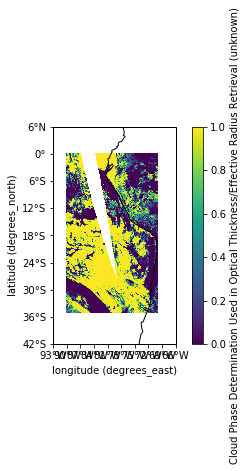

In [39]:
agg_mod_lr[6].plot()

In [23]:
data=SD(modis_daily[0], SDC.READ)

In [39]:
data.select('Cloud_Effective_Radius').attributes()

{'valid_range': [0, 10000],
 '_FillValue': -9999,
 'long_name': 'Cloud Particle Effective Radius two-channel retrieval using band 7(2.1um) and either band 1(0.65um), 2(0.86um), or 5(1.2um)  (specified in Quality_Assurance_1km)from best points: not failed in any way, not marked for clear sky restoral',
 'units': 'micron',
 'scale_factor': 0.009999999776482582,
 'add_offset': 0.0,
 'Parameter_Type': 'Output',
 'Cell_Along_Swath_Sampling': [1, 2030, 1],
 'Cell_Across_Swath_Sampling': [1, 1354, 1],
 'Geolocation_Pointer': 'External MODIS geolocation product'}

In [ ]:

#modis_day = days[0]
for modis_day in days:
    print('gridding for day {}/{}/{}'.format(modis_day, modis_month, modis_year))
    #ROI is UTC-5 so there is no daylight before ~1200 UTC --> Overpass time for Terra is around 1800 UTC
    #make a list of MODIS files on the day, check for overlap and delete those without 
    modis_daily = sorted(glob.glob(modis_dir.format(modis_year, modis_month, modis_day) + '*.hdf'))
    end_day = glob.glob(modis_dir.format(modis_year, modis_month, modis_day) + '*.2355.*.hdf')[0]
    end_day = modis_daily.index(end_day)
    start_time=glob.glob(modis_dir.format(modis_year, modis_month, modis_day) + '*.1500.*.hdf')[0]
    start_time=modis_daily.index(start_time)
    modis_daily = modis_daily[start_time:end_day]
    modis_daily=delete_no_overlap(modis_daily)

    
    #get data, need to do seperately because of different resolution
    mod_hr=read_data_list(modis_daily,
                       ['Cloud_Fraction',
                        'Cloud_Top_Temperature'])
    mod_lr=read_data_list(modis_daily,
                          ['Cloud_Effective_Radius','Cloud_Water_Path'], product='MOD06_HACK')
    
    
    #grid ungridded data to 0.1 deg grid, time dimension is collapsed (taking a mean?)
    agg_mod_lr=mod_lr.aggregate(x=[-90.0,-70.,0.1], y=[-35.,0.,0.1])
    agg_mod_hr=mod_hr.aggregate(x=[-90.0,-70.,0.1], y=[-35.,0.0,0.1])
    
    
    #add the two datasets together and save
    all_data=GriddedDataList([agg_mod_hr[0],agg_mod_hr[3], agg_mod_lr[0], agg_mod_lr[3]])
    all_data.save_data('/gws/nopw/j04/eo_shared_data_vol2/scratch/pete_nut/regrid_modis/'+modis_year+ modis_month + modis_day+".nc")
   
    